In [1]:
import tensorflow as tf
import numpy as np
from time import time
import os
import imageio
import copy
import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

# below is the setting of the path to /path/to/your/ffmpeg
plt.rcParams['animation.ffmpeg_path'] = "./ffmpeg-2022-12-08-git-9ca139b2aa-essentials_build/bin/ffmpeg.exe"

# defining the data type 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# rinitializjng the random seed
tf.random.set_seed(0)

In [2]:
class WaveModel(tf.keras.Sequential):
    def __init__(self, layers, lb, ub, a):
        super().__init__()
        # input in the form of 2 dimensions i.e t and x
        self.add(tf.keras.Input(2))
        # scaling layer
        scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0
        )
        self.add(scaling_layer)
        # hidden layers
        for n in layers:
            self.add(tf.keras.layers.Dense(
                n, 
                activation=tf.keras.activations.get('tanh'),
                kernel_initializer=tf.keras.initializers.GlorotNormal()
            ))
        # output layer
        self.add(tf.keras.layers.Dense(1))

        self.a = a

    def predict(self, X):
        return self.call(X)

    # residual of wave equation
    def _func_r(self, u_tt, u_xx):
        return u_tt - self.a * u_xx
    
    
    def get_r(self, X):
        with tf.GradientTape(persistent=True) as tape:
            t, x = X[:, 0:1], X[:, 1:2]
            tape.watch(t)
            tape.watch(x)

            u = self.call(tf.stack([t[:, 0], x[:, 0]], axis=1))
            u_t = tape.gradient(u, t)
            u_x = tape.gradient(u, x)

        u_tt = tape.gradient(u_t, t)
        u_xx = tape.gradient(u_x, x)

        r = self._func_r(u_tt, u_xx)
        return r
    

    def compute_loss(self, X0, u0, ut0, Xb, X_train, w_u0, w_ut0, w_ub, X0_val, u0_val, ut0_val, Xb_val):
        # equation loss
        r = self.get_r(X_train)
        l0 = tf.reduce_mean(tf.square(r))

        # boundary loss at u(x, t=0)
        u0_pred = self.call(X0)
        l1 = tf.reduce_mean(tf.square(u0_pred - u0))

        u0_pred_val = self.call(X0_val)
        l1_val = tf.reduce_mean(tf.square(u0_pred_val - u0_val))

        # boundary loss at u_t(x, t=0)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X0)
            tape.watch(X0_val)
            u0_pred = self.call(X0) 
            u0_pred_val = self.call(X0_val)
        ut0_pred = tape.batch_jacobian(u0_pred, X0)[:, :, 0]
        ut0_pred_val = tape.batch_jacobian(u0_pred_val, X0_val)[:, :, 0]
        l2 = tf.reduce_mean(tf.square(ut0_pred - ut0))
        l2_val = tf.reduce_mean(tf.square(ut0_pred_val - ut0_val))

        # boundary loss at border 
        # loss set as ub_x = 0 
        ubx_pred = self.call(Xb)
        ubx_pred_val = self.call(Xb_val)
        l3 = tf.reduce_mean(tf.square(ubx_pred))
        l3_val = tf.reduce_mean(tf.square(ubx_pred_val))

        # summary of loss
        loss = l0 + w_u0 * l1 + w_ut0 * l2 + w_ub * l3
        loss_val = w_u0 * l1_val + w_ut0 * l2_val + w_ub * l3_val
        return loss, loss_val
    
    # calculating gradients of the network
    def get_grad(self, X0, u0, ut0, Xb, X_train, w_u0, w_ut0, w_ub, X0_val, u0_val, ut0_val, Xb_val):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.trainable_variables)
            loss, loss_val = self.compute_loss(X0, u0, ut0, Xb, X_train, w_u0, w_ut0, w_ub, X0_val, u0_val, ut0_val, Xb_val)
        grad = tape.gradient(loss, self.trainable_variables)
        return grad, loss, loss_val
    
    # fitting the data by training
    def fit(self, X0, u0, ut0, Xb, ub, X_train, w_u0, w_ut0, w_ub, N_iter=1000, optimizer=None):
        if optimizer is None:
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        
        # splitting for training and validation purpose data: 80% for train, 20% for validation
        X0_train, X0_val = tf.split(X0, [int(0.8*X0.shape[0]), int(0.2*X0.shape[0])], axis=0)
        u0_train, u0_val = tf.split(u0, [int(0.8*u0.shape[0]), int(0.2*u0.shape[0])], axis=0)
        ut0_train, ut0_val = tf.split(ut0, [int(0.8*ut0.shape[0]), int(0.2*ut0.shape[0])], axis=0)
        Xb_train, Xb_val = tf.split(Xb, [int(0.8*Xb.shape[0]), int(0.2*Xb.shape[0])], axis=0)
        # ub = 0, ignored here

        @tf.function
        def train_step():
            grad_theta, loss, loss_val = self.get_grad(X0_train, u0_train, ut0_train, Xb_train, X_train, w_u0, w_ut0, w_ub, X0_val, u0_val, ut0_val, Xb_val)
            optimizer.apply_gradients(zip(grad_theta, self.trainable_variables))
            return loss, loss_val

        hist_train = []
        hist_val = []
        t0 = time()

        for i in range(N_iter+1):
            loss_train, loss_val = train_step()
            # loss_b1, loss_b2 = self.get_bound_r(X0_val, u0_val, ut0_val)
            hist_train.append(loss_train.numpy())
            # hist_val.append(w_u0 * loss_b1.numpy() + w_ut0 * loss_b2.numpy())
            hist_val.append(loss_val.numpy())

            if i%10 == 0:
                print('\r iteration: {:05d}, train loss: {:10.8e} test bound loss: {:10.8e}'.format(i, loss_train, loss_val), end='')
            if i%1000 == 0:
                print('')

        print('\n')
        print('time: {:.2f} sec'.format(time() - t0))
        print('final train loss: {:10.8e}'.format(loss_train))

        return hist_train, hist_val

In [3]:
a = 1
x_min, x_max = -5, 5
t_min, t_max = 0, 10

In [4]:
N_train = 1000  # points along every dimension
t_train = tf.random.uniform((N_train, 1), t_min, t_max, dtype=DTYPE)
x_train = tf.random.uniform((N_train, 1), x_min, x_max, dtype=DTYPE)
X_train = tf.concat([t_train, x_train], axis=1)

In [5]:
N_init = 1000
x_init = tf.cast(tf.linspace([x_min], [x_max], N_init), DTYPE)  # '[]' here to create (N, 1) shape
t_init = tf.ones_like(x_init, dtype=DTYPE) * t_min   # t_min=0 here
X_init = tf.concat([t_init, x_init], axis=1)

# the u(t=0, x)
u_init = tf.exp(-tf.square(x_init))

# the u_t(t=0, x)
ut_init = 2*a*x_init*u_init

In [6]:
N_bound = 1000
t_bound = tf.cast(tf.linspace([t_min], [t_max], N_bound), DTYPE)
x_bound = tf.ones_like(t_bound, dtype=DTYPE) * x_max
X_bound = tf.concat([t_bound, x_bound], axis=1)

# the u(t, x=x_max)
u_bound = tf.zeros_like(t_bound, dtype=DTYPE)

In [7]:
w_u_init, w_ut_init, w_u_bound = 1, 1, 1 

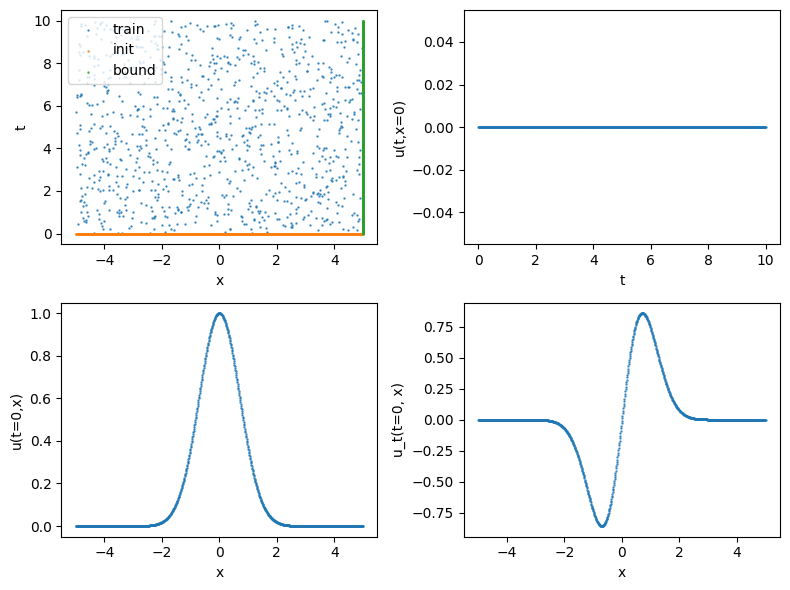

In [8]:
fig = plt.figure(figsize=(8, 6))

ax11 = fig.add_subplot(221)
ax11.scatter(x_train, t_train, s=2, marker='.', alpha=0.8, label='train')
ax11.scatter(x_init, t_init, s=2, marker='.', alpha=0.8, label='init')
ax11.scatter(x_bound, t_bound, s=2, marker='.', alpha=0.8, label='bound')
ax11.set_xlabel('x')
ax11.set_ylabel('t')
ax11.legend(loc='upper left')

ax12 = fig.add_subplot(222)
ax12.scatter(t_bound, u_bound, s=2, marker='.', alpha=0.8)
ax12.set_xlabel('t')
ax12.set_ylabel('u(t,x=0)')

ax21 = fig.add_subplot(223)
ax21.scatter(x_init, u_init, s=2, marker='.', alpha=0.8)
ax21.set_xlabel('x')
ax21.set_ylabel('u(t=0,x)')

ax22 = fig.add_subplot(224)
ax22.scatter(x_init, ut_init, s=2, marker='.', alpha=0.8)
ax22.set_xlabel('x')
ax22.set_ylabel('u_t(t=0, x)')

fig.tight_layout()
plt.show()
plt.close(fig=fig)

In [9]:
layers = [10, 10, 10, 10]   
lb = tf.constant([t_min, x_min], dtype=DTYPE)   
ub = tf.constant([t_max, x_max], dtype=DTYPE)   
model = WaveModel(layers, lb, ub, a)

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [11]:
N_iter = 10000
hist_train, hist_val = model.fit(
    X_init, u_init, ut_init, 
    X_bound, u_bound, 
    X_train, 
    w_u_init, w_ut_init, w_u_bound, 
    N_iter=N_iter, 
    optimizer=optimizer
)

 iteration: 00000, train loss: 3.40791285e-01 test bound loss: 5.37393987e-02
 iteration: 01000, train loss: 7.74032949e-03 test bound loss: 9.12288204e-04
 iteration: 02000, train loss: 7.14908494e-03 test bound loss: 2.48240947e-04
 iteration: 03000, train loss: 4.77021746e-03 test bound loss: 6.68643857e-04
 iteration: 04000, train loss: 3.22892168e-03 test bound loss: 2.63196707e-05
 iteration: 05000, train loss: 2.04909849e-03 test bound loss: 6.55359763e-04
 iteration: 06000, train loss: 5.91477146e-04 test bound loss: 1.24466693e-04
 iteration: 07000, train loss: 3.70418420e-04 test bound loss: 6.35359829e-05
 iteration: 08000, train loss: 2.39434754e-04 test bound loss: 3.26479349e-05
 iteration: 09000, train loss: 3.56541219e-04 test bound loss: 1.71067179e-04
 iteration: 10000, train loss: 1.18576128e-04 test bound loss: 2.04546668e-04


time: 71.07 sec
final train loss: 1.18576128e-04


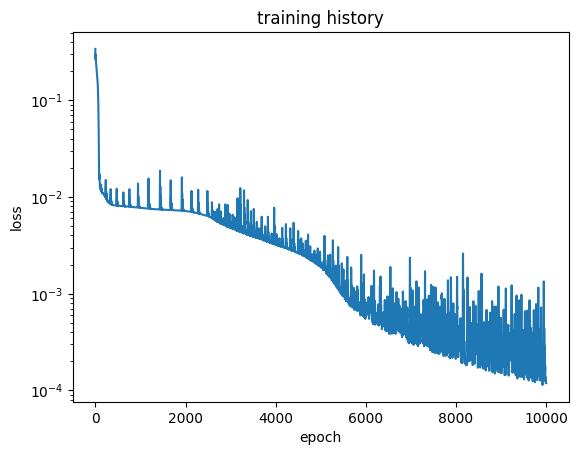

In [12]:
plt.semilogy(hist_train)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training history')
plt.show()
plt.close()

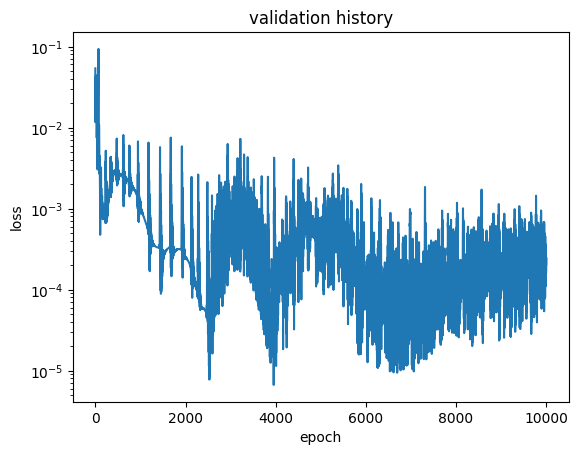

In [13]:
plt.semilogy(hist_val)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('validation history')
plt.show()
plt.close()